In [1]:
# import libraries
from pyopenms import * # main package used for handling MS data
import os # changing directories
import pandas as pd # to read in tsv and for dataframe creation/manipulation
import subprocess # running R script 
import matplotlib.pyplot as plt # for bar graph

In [2]:
# change directory to find data files of interest
os.chdir(r'C:\Users\miar\Desktop\data')

In [3]:
# experiment files 
mzML = 'HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP.mzML'
log = 'App-2022-05-31_20-49-35.log'
realtime = 'HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP_realtimesearch.tsv'

In [4]:
# load the content of the mzML file into the exp variable of type MSExperiment
exp = MSExperiment()
MzMLFile().load(mzML, exp)

# access the raw data and spectra
#spectrum_data = exp.getSpectrum(0).get_peaks()
#spectrum_data

In [5]:
# loop through the spectra to filter MS2 and MS3 scans
specM2 = []
specM3 = []
for s in exp.getSpectra():
    if s.getMSLevel() == 2:
        specM2.append(s)
    elif s.getMSLevel() == 3:
        specM3.append(s)
        
print("Number of MS2 scans: " + str(len(specM2)))
print("Number of MS3 scans: " + str(len(specM3)))

# store the modified data structure on disk
# can only save one at a time or data overwrites....
#MzMLFile().store("filtered.mzML", exp)

Number of MS2 scans: 74458
Number of MS3 scans: 2727


In [6]:
# parse functions
def parseScanLine(input):
    x = input.split(" For: ")
    [scan_number, mzs] = x[1].split(", ")
    [precursor_mz, fragment_mz] = mzs.split(";")
    trimmed_fragment_mz = fragment_mz.strip() # trim fragment strings to remove \n
    return [scan_number, precursor_mz, trimmed_fragment_mz]

def parseTargetIons(input):
    i = input.split('Target Fragment: ')
    ion = i[1].split(',')[0]
    return ion 

In [7]:
# checking lines of log file and creating dictionary of scan numbers and fragment mzs
try:
  
    # words to search for
    search = ' Submitted Custom Scan For:'
    search_target = 'Target Fragment:'
    
    # dict for scan numbers and corresponding fragments 
    scan2frag = dict()
    target_values = []
    with open(log) as f:
        for line in f:
            if search in line:
                scan_number, precursor_mz, trimmed_fragment_mz = parseScanLine(line)
                scan2frag[scan_number] = [float(precursor_mz), float(trimmed_fragment_mz)]
            elif search_target in line:
                target_ion = parseTargetIons(line)
                target_values.append(target_ion) #to add to final dataframe
            
    # if the input string doesn't exist in the text file
    if len(scan2frag)==0:
        print("\n\"" + search + "\" is not found in \"" + log + "\"!")

except FileNotFoundError:
    print("The file does not exist!")

In [8]:
# read in peptide sequence from tsv
tsv = pd.read_csv(realtime, sep='\t')

# create dictionary with scan # as key and sequence/charge as values
scan2PeptideCharge = dict([(i, [x,y]) for i, x,y, in zip(tsv['Scan Number'], tsv['Peptide'], tsv['Charge State'])])

# removing all NaN sequences (not useful)
scan2PeptideCharge_modified = {k:v for k,v in scan2PeptideCharge.items() if str(v[0]) != 'nan'}

In [9]:
def findFragments(peptide_object, charge):
    # loop through each prefix and suffix (b and y ions, respectively)
    # y and b ions

    b_index = []
    y_index = []
    for ion in range(1, (peptide_object.size())): # start at index of 1, end at peptide length - 1
        y_ion = peptide_object.getSuffix(ion)
        b_ion = peptide_object.getPrefix(ion)

        for z in range(1, charge):
            mz_b = b_ion.getMonoWeight(Residue.ResidueType.BIon, z) / z
            b_index.append(s.findNearest(mz_b, 0.4))

            mz_y = y_ion.getMonoWeight(Residue.ResidueType.YIon, z) / z
            y_index.append(s.findNearest(mz_y, 0.4))

    y_index.reverse() # reverse list (the first b ion corresponds with the last y ion)
    
    # skim list for each corresponding y and b fragments based on charge states
    count = 0
    missing_list = []
    for fragment_index in range(0, len(y_index), charge-1): # check after 'x' mzs (possible charge states)
        
        count = count + 1
        
        check_b = b_index[fragment_index : fragment_index+charge-1]
        check_y = y_index[fragment_index : fragment_index+charge-1]

        if all(item == -1 for item in check_b) and all(item == -1 for item in check_y):
            missing_list.append(str(count))
        
        number_missing = len(missing_list)
        missing_list_mod = ",".join(str(i) for i in missing_list)

    return missing_list_mod, number_missing

In [10]:
table_rows = []
for s in specM2:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
    
    if scan_number in scan2frag and int(scan_number) in scan2PeptideCharge_modified:
        # isolate peptide sequence from dict
        sequence = scan2PeptideCharge_modified[int(scan_number)][0]     
        trimmed_sequence = sequence[2:-2] # remove first two and last two characters 
        
        # isolate charge from dict
        charge = scan2PeptideCharge_modified[int(scan_number)][1]
 
        # create peptide object 
        peptide_object = AASequence.fromString(trimmed_sequence)
        
        # call findFragments function
        missing_list_mod, number_missing = findFragments(peptide_object, charge)
        
        # creating table
        #myTable.add_row([scan_number, trimmed_sequence, peptide_object.size(), missing_list])
        add_row = {'Scan_Number':scan_number, 
                'Sequence':trimmed_sequence,
                   'Charge':charge,
                'Sequence_Length':peptide_object.size(),
                'Missing_Fragment_Locations':missing_list_mod,
                   'Number_Missing':number_missing}
        table_rows.append(add_row)

In [11]:
# create dataframe to be exported as table later 
df = pd.DataFrame(table_rows)
# add targeted fragment column and precursor mz column
fragment_df = df.assign(Target_Fragment=target_values)

In [12]:
# export df to tsv 
fragment_df.to_csv('fragmentInfoTable.tsv', sep=' ', index=False)

In [13]:
# perform table modifications and plot histograms in R...
# ...
# ...
subprocess.run(r'Rscript C:\Users\miar\Desktop\data\fragmentStatistics.R', shell=True)

CompletedProcess(args='Rscript C:\\Users\\miar\\Desktop\\data\\fragmentStatistics.R', returncode=0)

In [14]:
# read in modified table
checktargets_df = pd.read_csv('fragmentInfoTable_altered.tsv', sep="/t", engine='python')

In [15]:
# find all precursor and fragment mzs from log (used for MS3 matching)
precursor_mzs = []
fragment_mzs = []

for scan in list(scan2frag):
    precursor_mzs.append(scan2frag[scan][0])
    fragment_mzs.append(scan2frag[scan][1])

In [16]:
# obtain MS3 scan numbers
# obtain precursor and fragment mzs directly from the MS3 spectrum

ms3scan2MZs = dict()
for s in specM3:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
   
    fragment, precursor = s.getPrecursors()
    precursor_mz = precursor.getMZ()
    fragment_mz = fragment.getMZ()
    
    ms3scan2MZs[int(scan_number)] = [round(float(precursor_mz), 4), round(float(fragment_mz), 4)] # 4 decimal places, similar to log

In [17]:
def matchingMS3s(which_mz_list, type_str): # either fragment or precursor
    
    values = []
    
    if type_str == 'Precursor mzs':
        for i in list(ms3scan2MZs.values()):
            value = i[0]
            values.append(value)
    elif type_str == 'Fragment mzs':
        for i in list(ms3scan2MZs.values()):
            value = i[1]
            values.append(value)
    
    # making sure they are within 100 scans of each other
    too_far = []
    for ms2scan, ms3scan in zip(list(scan2frag), list(ms3scan2MZs)):
        scan_diff = int(ms3scan) - int(ms2scan)
        if scan_diff > 100:
            too_far.append('Scans are not within 100 scans of each other...' + 'MS2 = ' + ms2scan + ' MS3 = ' + ms3scan)
    
    # do they not match off the bat?
    if values != which_mz_list:
        
        # taking into consideration rounding discrepencies between the log and the spectrum
        mismatch = []
        for i in range(0, len(which_mz_list)):
            diff = float(values[i]) - float(which_mz_list[i]) 
            if diff < 0.000101 or (diff < 0 and diff > -0.000101): # because sometimes max number will be 0.0001000002 for example
                pass
            else:
                mismatch.append(i)
                
        # no mismatch after rounding and within 100 scans
        if len(mismatch) == len(too_far) == 0:
            print(type_str + ' match up after taking rounding discrepencies into consideration')
            new_fragment_df = fragment_df.assign(MS3_Scan = list(ms3scan2MZs))
            return new_fragment_df
        elif len(mismatch) != 0:
            print('There is mismatch at the following indicies:') # if this is the case, need to do more work...
            for i in mismatch:
                print(i) 
        elif len(too_far) != 0:
            print(too_far)
       
    # they match perfectly
    elif values == which_mz_list:
        
        # within 100 scans
        if len(too_far) == 0:
            print(type_str + ' match up perfectly!')
            new_fragment_df = fragment_df.assign(MS3_Scan = list(ms3scan2MZs))
            return new_fragment_df
        else:
            print(too_far)

In [18]:
# matching precursor mzs between MS2 (log) and MS3 (spectrum)
df1 = matchingMS3s(precursor_mzs, 'Precursor mzs')

# matching fragment mzs between MS2 (log) and MS3 (spectrum)
df2 = matchingMS3s(fragment_mzs, 'Fragment mzs')

if df1.equals(df2):
    new_fragment_df =  df1

Precursor mzs match up after taking rounding discrepencies into consideration
Fragment mzs match up perfectly!


In [19]:
# after making sure MS2s and MS3s line up, we can continue...

In [20]:
# fragments that were not found in MS2 but potentially could be found in MS3
ms3could_help = []
ms3no_help = []

for i in checktargets_df.index:
    # target y ions
    if str(checktargets_df['"Target_Fragment"'][i]).startswith('"y'):
        if str(checktargets_df.loc[i]['"cTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"cTerminusEnd"'][i]):
            ms3could_help.append(i)
        else:
            ms3no_help.append(i)
         
    # target b ions
    elif str(checktargets_df['"Target_Fragment"'][i]).startswith('"b'):
        if str(checktargets_df.loc[i]['"nTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"nTerminusEnd"'][i]):
            ms3could_help.append(i)
        else: 
            ms3no_help.append(i)
    else:
        ms3no_help.append(i)

# create new df with only fragments of interest (to be checked in MS3)
checkfrags_df = checktargets_df.drop(ms3no_help, axis=0)

# remove now irrelevant info 
checkfrags_df.drop(columns=['"Sequence"', '"Sequence_Length"', '"Number_Missing"', '"Target_Fragment"', '"cTerminusEnd"'], inplace=True)

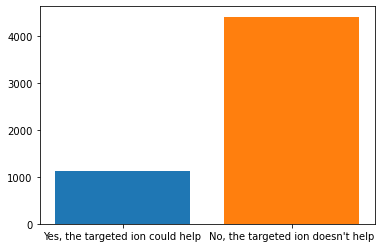

In [21]:
# visualize the percentage of fragments that could potentially be found in MS3
plt.bar('Yes, the targeted ion could help', len(ms3could_help))
plt.bar('No, the targeted ion doesn\'t help', len(ms3no_help))
plt.show()

In [22]:
def findFragmentsMS3(peptide_object, charge, i):
    
    y_index = []
    b_index = []

    # targeted fragment is a y ion
    if new_fragment_df['Target_Fragment'][i].startswith('y'):
        y_num = new_fragment_df['Target_Fragment'][i][-1]

        # the full sequence of the fragment
        full_seq = peptide_object.getSuffix(int(y_num))

        # checking fragment for its y ions
        for ion in range(1, int(y_num)):
            y_ion = full_seq.getSuffix(ion)
            for z in range(1, charge):
                mz_y = y_ion.getMonoWeight(Residue.ResidueType.YIon, z) / z
                y_index.append(specM3[i].findNearest(mz_y, 0.4))

        # reverse list (the first b ion corresponds with the last y ion)
        y_index.reverse() 

        # checking fragment for b ions
        for ion in range(1, int(y_num)):
            b_ion = full_seq.getPrefix(ion)
            for z in range(1, charge):
                mz_b = b_ion.getMonoWeight(Residue.ResidueType.Internal, z) / z
                b_index.append(specM3[i].findNearest(mz_b, 0.4))
                
    # targeted fragment is a b ion
    elif new_fragment_df['Target_Fragment'][i].startswith('b'):
        b_num = new_fragment_df['Target_Fragment'][i][-1]

        # the full sequence of the fragment
        full_seq = peptide_object.getPrefix(int(b_num))

        # checking fragment for its b ions
        for ion in range(1, int(b_num)):
            b_ion = full_seq.getPrefix(ion)
            for z in range(1, charge):
                mz_b = b_ion.getMonoWeight(Residue.ResidueType.BIon, z) / z
                b_index.append(specM3[i].findNearest(mz_b, 0.4))

        # checking fragment for y ions
        for ion in range(1, int(b_num)):
            y_ion = full_seq.getPrefix(ion)
            for z in range(1, charge):
                mz_y = y_ion.getMonoWeight(Residue.ResidueType.Internal, z) / z
                y_index.append(specM3[i].findNearest(mz_y, 0.4))

        # reverse list (the first b ion corresponds with the last y ion)
        y_index.reverse()

    count = 0
    foundinMS3 = []
    for fragment_index in range(0, len(y_index), charge-1): # check after 'x' mzs (possible charge states)

        count = count + 1

        check_y = y_index[fragment_index : fragment_index+charge-1]
        check_b = b_index[fragment_index : fragment_index+charge-1]

        if all(item == -1 for item in check_b) and all(item == -1 for item in check_y): # missing fragments
            pass 
        else:
            foundinMS3.append(count) # fragments found (distance from n terminus of target frag)

    return foundinMS3, str(full_seq)

In [23]:
found_list = [] # the b and y ions that were found in the MS3 sepctra
fragment_seqs = [] # the sequence of the fragment (needed to find location from n terminus)
for i in new_fragment_df.index:
    
    # create peptide object for the sequence
    peptide_object = AASequence.fromString(new_fragment_df['Sequence'][i])
    
    # the charge associated with this sequence
    charge = new_fragment_df['Charge'][i]
    
    # call findFragmentsMS3 function 
    foundinMS3, full_seq = findFragmentsMS3(peptide_object, charge, i)
    
    found_list.append(foundinMS3)
    fragment_seqs.append(full_seq)

In [24]:
# modifying dataframe to make life easier (hopefully)

# change full sequences to fragment sequences 
new_fragment_df = new_fragment_df.assign(Fragment_Sequence = fragment_seqs)

# add column of locations found in fragment 
new_fragment_df = new_fragment_df.assign(Locations_Found=found_list)

# remove any rows with no locations found (empty lists)
for i in new_fragment_df.index:
    if new_fragment_df['Locations_Found'][i] == []:
        new_fragment_df.drop(i, axis=0, inplace=True)

In [25]:
# currently, 'locations found' represents distance from n terminus for the FRAGMENT sequence 
# want the location as a distance from the n terminus for the entire peptide sequence 
# can then easily match locations between MS3 and MS2
locations = []
for i in new_fragment_df.index:
    if new_fragment_df['Target_Fragment'][i].startswith('y'):
        frag_length = len(new_fragment_df['Fragment_Sequence'][i])
        whole_seq_length = new_fragment_df['Sequence_Length'][i]
        starting_loc = whole_seq_length - frag_length # starting point - location from n terminus 
        
    elif new_fragment_df['Target_Fragment'][i].startswith('b'):
        starting_loc = 0 # starts at beginning of sequence

    test = []
    for x in new_fragment_df['Locations_Found'][i]:
        location = starting_loc + x
        
        test.append(location)
        
    locations.append(test) # distance away from n terminus 

# overwrite locations column to resemble location from n terminus for entire sequence 
new_fragment_df['Locations_Found'] = locations

# clean up df to remove info that is now irrelevant
checkMS3 = new_fragment_df.drop(columns=['Charge', 'Sequence_Length', 'Target_Fragment', 'Number_Missing', 'Missing_Fragment_Locations'])

In [26]:
#checkMS3 # all frags found in MS3

,Scan_Number,Sequence,MS3_Scan,Fragment_Sequence,Locations_Found
1,2534,RQVPLASPSSM[15.9949]SAALRGISCYLKE,2543,CYLKE,"[22, 23]"
3,3582,KSSM[15.9949]KRKLPFTISPSRNE,3585,RNE,[16]
9,4150,KPATDPVLQVVYKSQGKE,4153,KPATDP,"[1, 5]"
12,4239,AYYRRVKRLYSNWRKGE,4242,KGE,[16]
13,4246,CSRAGGNCCKKCTLTHD,4248,CSRAGG,"[2, 4]"
...,...,...,...,...,...
2699,79115,AIGVIFTHVRLLARAFTLRTVGFNHLTLGHNQRME,79124,NQRME,"[31, 33, 34]"
2702,79440,QVTVNKARAPAFSMGIRHSKRASTM[15.9949]AATTPSRPAGHR...,79443,GRCC,"[41, 42]"
2704,79459,MLIPMASVMAVTEPKWVSVWSRFLWVTLLSM[15.9949]VLGSLL...,79465,LGAVE,[44]
2712,79736,LQRSLPPVMAQNLSIPLAFACLLHLANE,79746,LQRSL,"[1, 4]"


In [27]:
#checkfrags_df # frags missing from MS2

,"""Scan_Number""","""Charge""","""nTerminusEnd"""
10,2534,4,21
11,2534,4,22
12,2534,4,23
13,3148,4,1
14,3148,4,2
...,...,...,...
5544,80065,3,27
5545,80065,3,28
5546,80065,3,29
5547,80065,3,30


In [28]:
ms3_index = list(checkMS3.index) # so we can easily check between dataframes with different indices
found = [] # list of fragments found (missing in MS2, were found in MS3)

# look throughout both dataframes to find any missing fragments
for i in checkfrags_df.index:
    scan = checkfrags_df['"Scan_Number"'][i]
    
    # for scans in both dataframes 
    if str(scan) in list(checkMS3['Scan_Number']):
        
        # what is the index of this scan in the checkMS3 df?
        for ind in ms3_index:
            if str(scan) == checkMS3['Scan_Number'][ind]:
                index = ind
        
        # if there is only one location found in MS3 to check
        if len(checkMS3['Locations_Found'][index]) == 1:
            if checkMS3['Locations_Found'][index] == [int(checkfrags_df['"nTerminusEnd"'][i])]:
                found.append('Location matched')
                #print(checkMS3.iloc[index])
                #print(int(checkfrags_df['"nTerminusEnd"'][i]))
        
        # multiple locations to check in a single scan
        elif len(checkMS3['Locations_Found'][index]) > 1:
            
            if any(loc == int(checkfrags_df['"nTerminusEnd"'][i]) for loc in checkMS3['Locations_Found'][index]):
                found.append('Location matched')

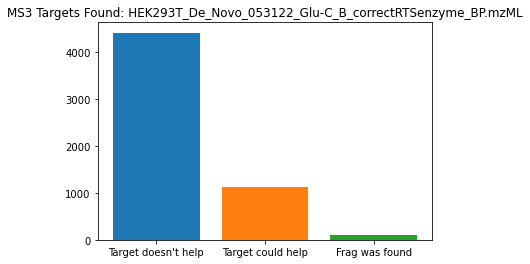

In [29]:
# visualize the percentage of fragments that could potentially be found in MS3 and those that were actually found
plt.bar('Target doesn\'t help', len(ms3no_help))
plt.bar('Target could help', len(ms3could_help))
plt.bar('Frag was found', len(found))
plt.title('MS3 Targets Found: ' + mzML)
plt.show()